In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
QUANDL_KEY = 'oEY4by7XiFVhyWsyVYyC' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2000-01-01', 
                end_date='2021-02-28')

df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [7]:
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (242, 1)


,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-30,279.69
2000-05-31,275.19


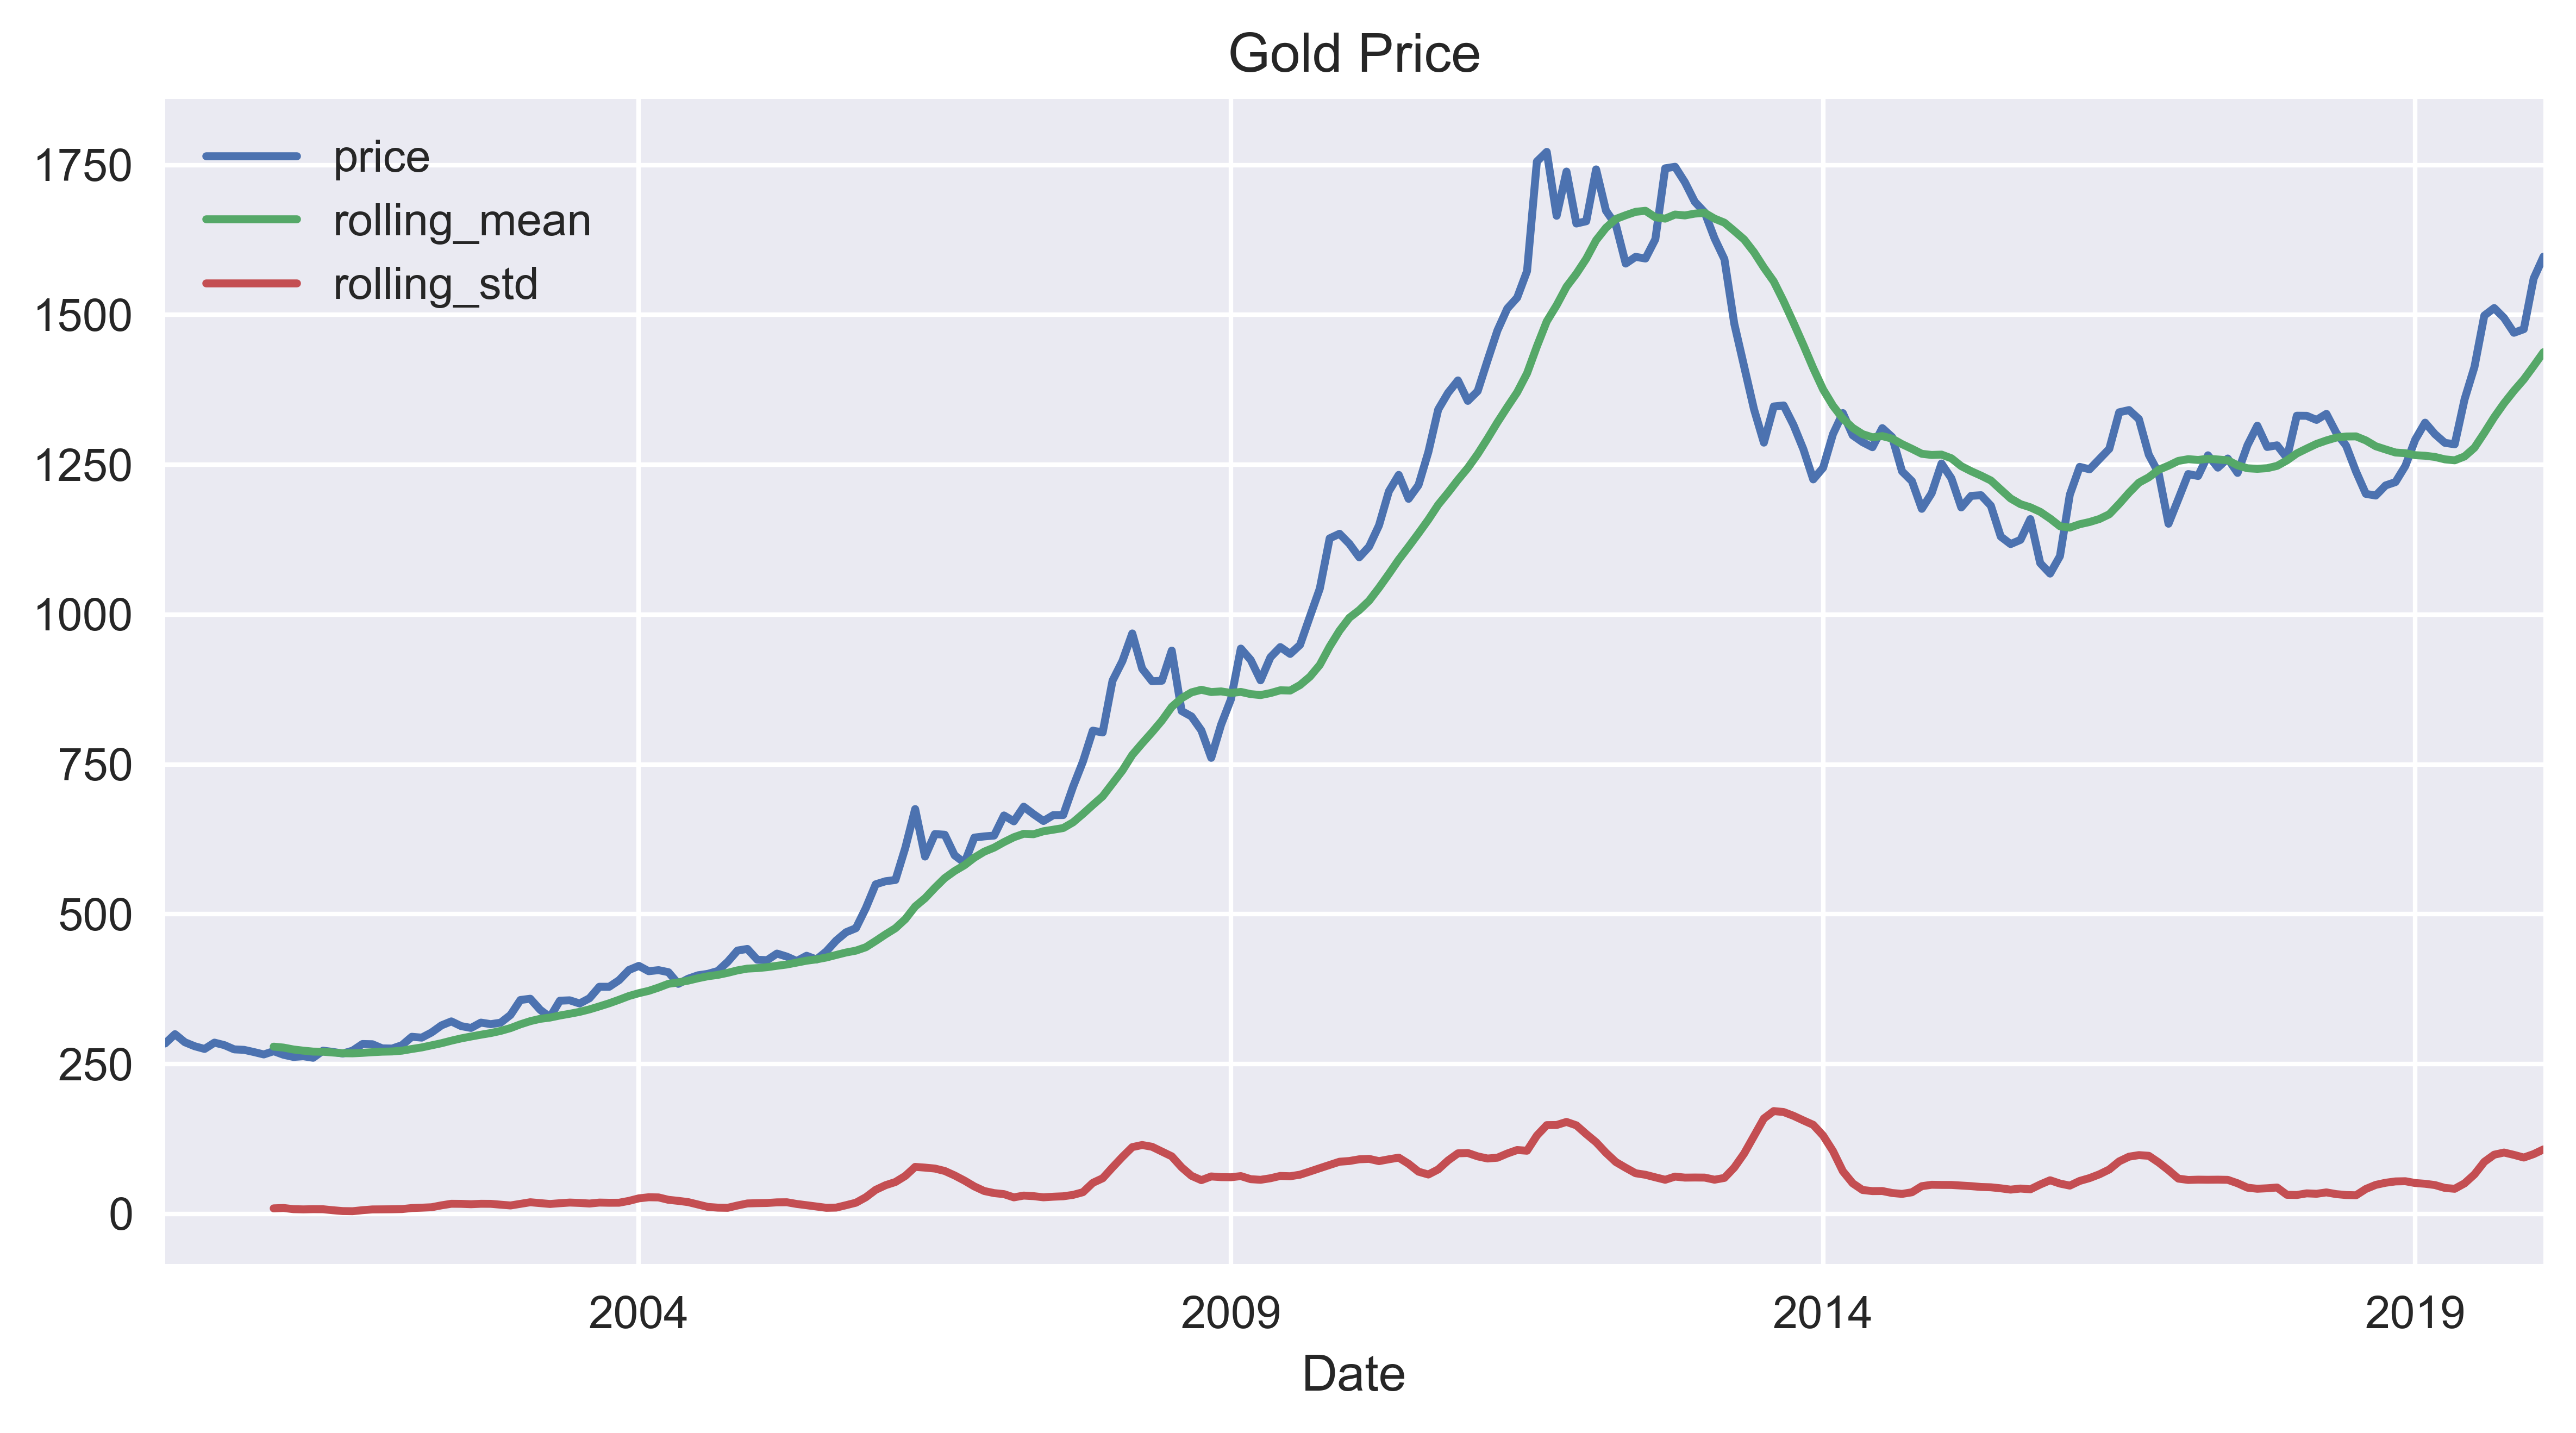

In [8]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

plt.tight_layout()
#plt.savefig('images/ch3_im1.png')
plt.show()

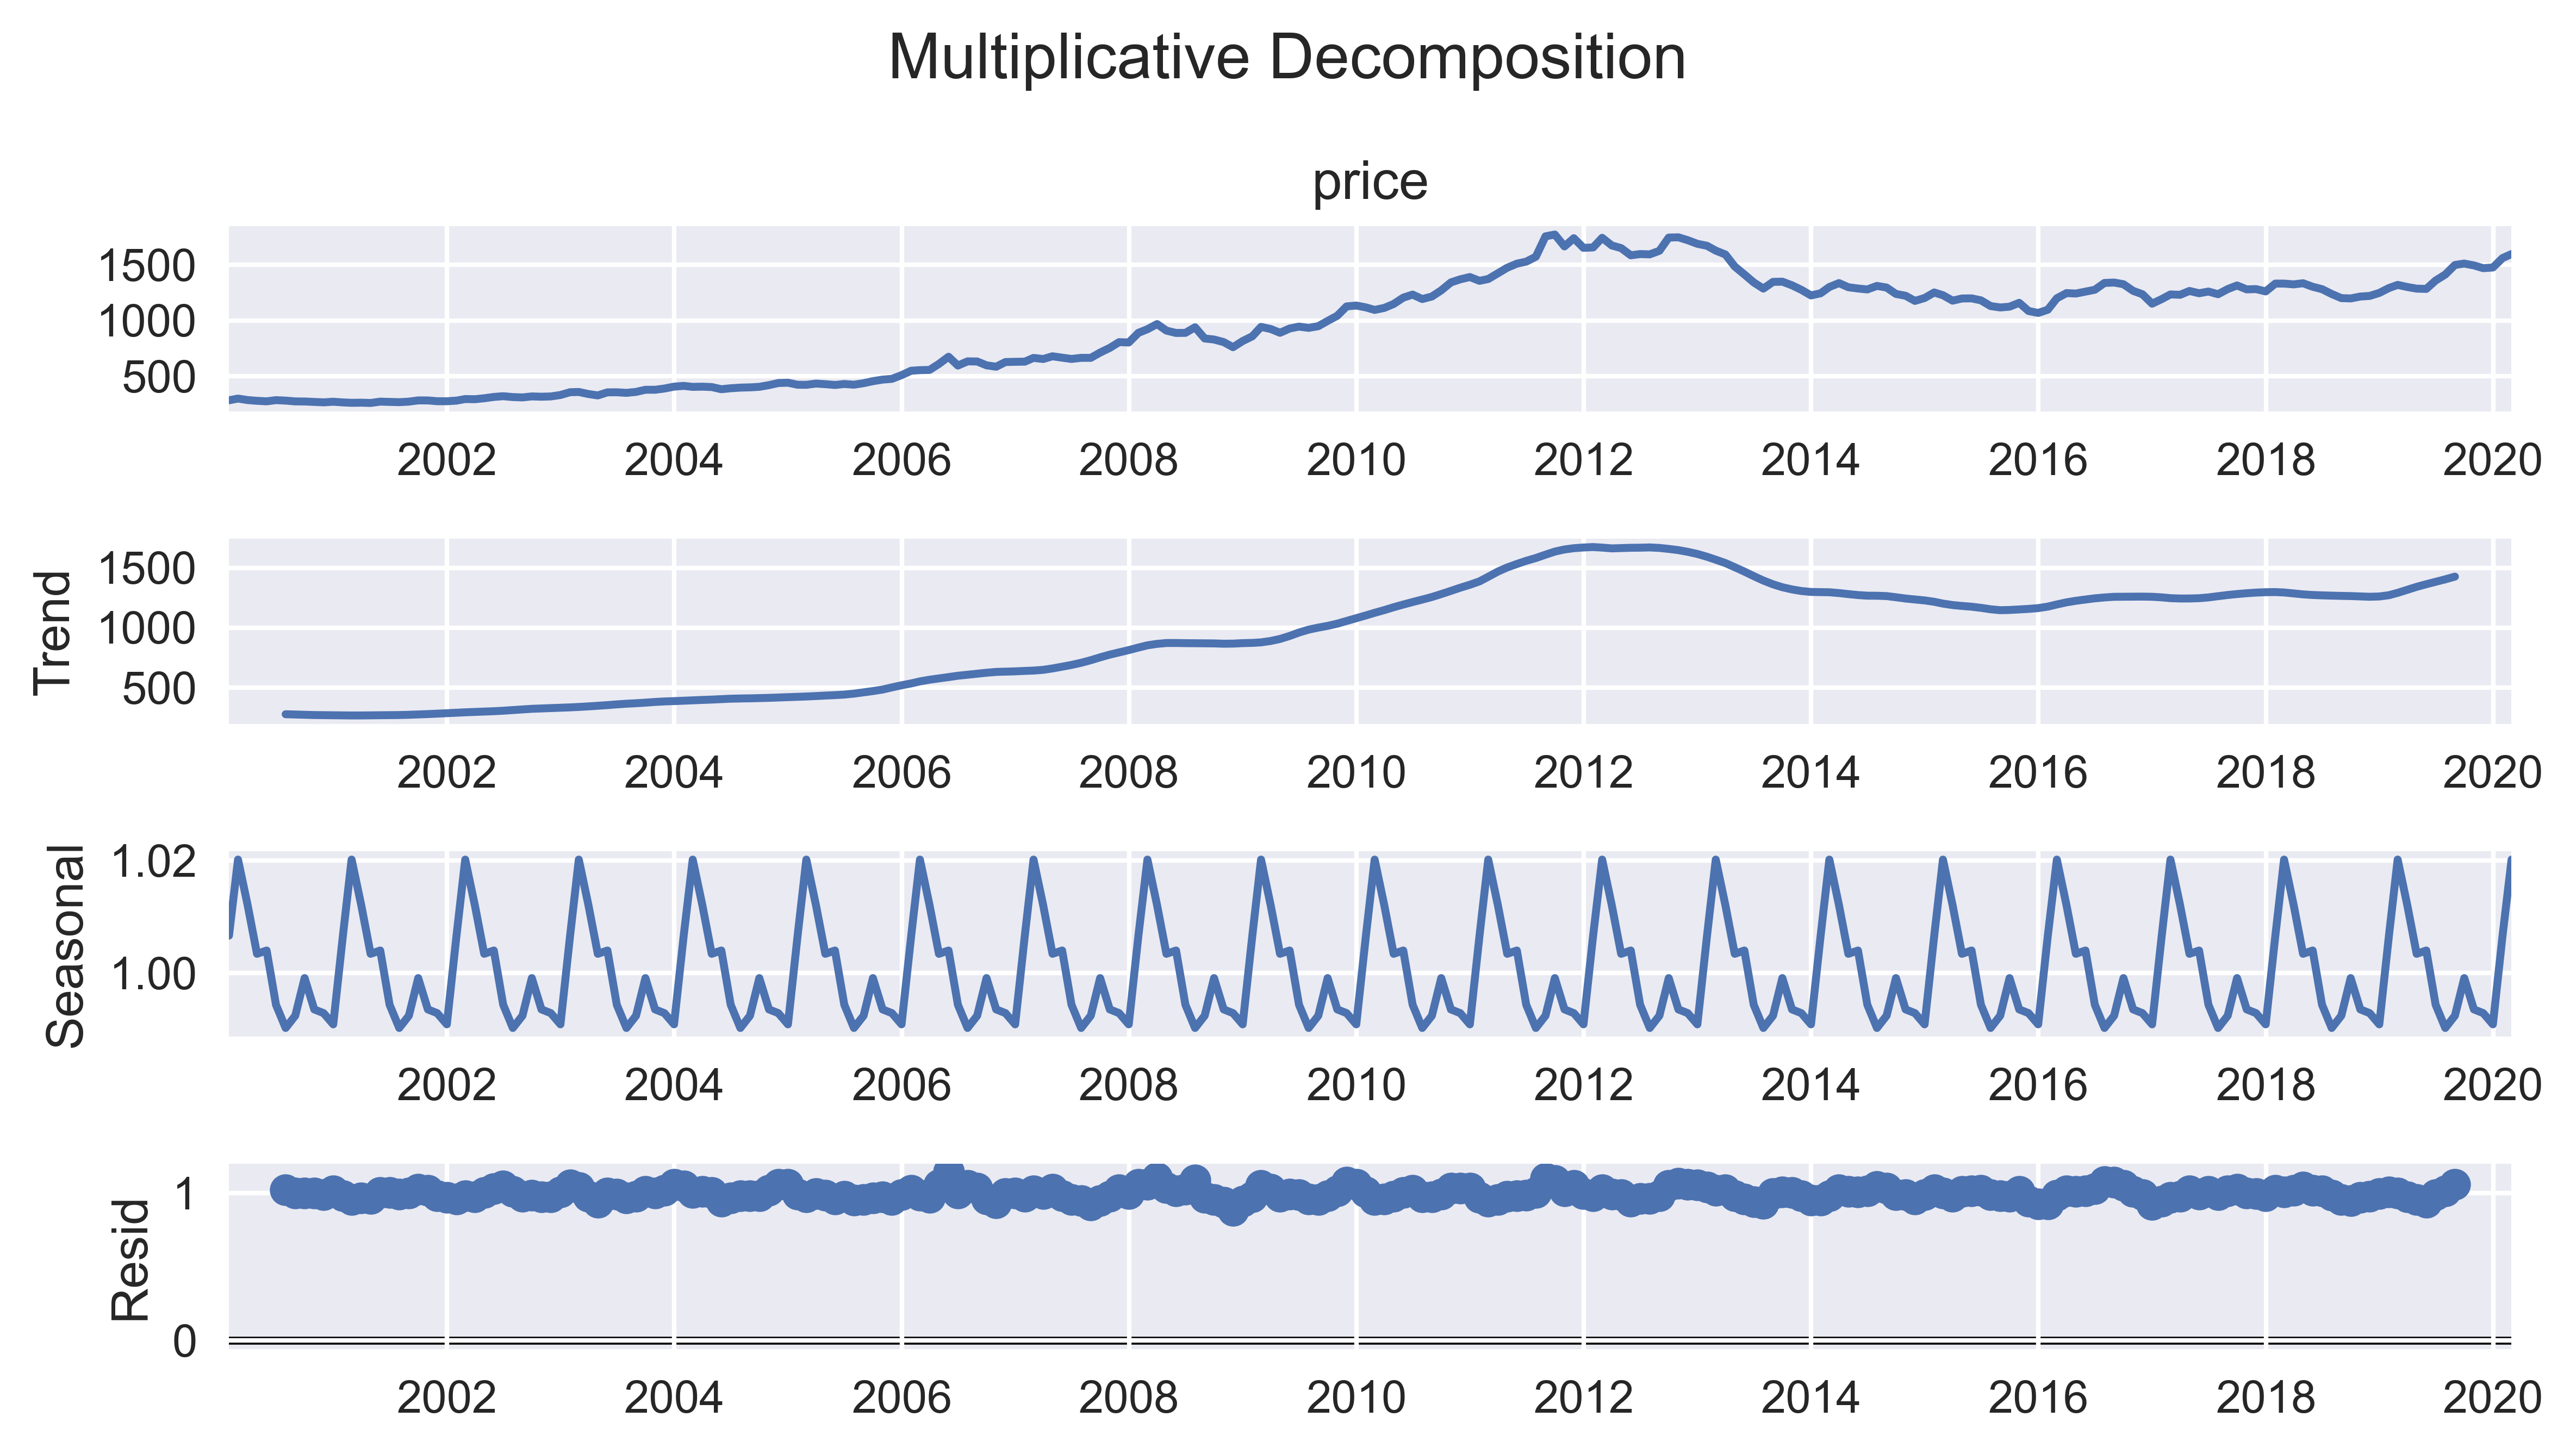

In [9]:
decomposition_results = seasonal_decompose(df.price, 
                                           model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', 
                               fontsize=14)

plt.tight_layout()
# plt.savefig('images/ch3_im2.png')
plt.show()

In [10]:
print("Decomposing time series using Facebook's Prophet")

Decomposing time series using Facebook's Prophet


In [11]:
import pandas as pd
import seaborn as sns
import quandl
from fbprophet import Prophet

QUANDL_KEY = 'oEY4by7XiFVhyWsyVYyC' # replace {key} with your own API key 
quandl.ApiConfig.api_key = QUANDL_KEY

Importing plotly failed. Interactive plots will not work.


In [12]:
df = quandl.get(dataset='WGC/GOLD_DAILY_USD',
                start_date='2000-01-01',
                end_date='2021-02-28')

df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)

In [13]:
train_indices = df.ds.apply(lambda x: x.year).values < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [14]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


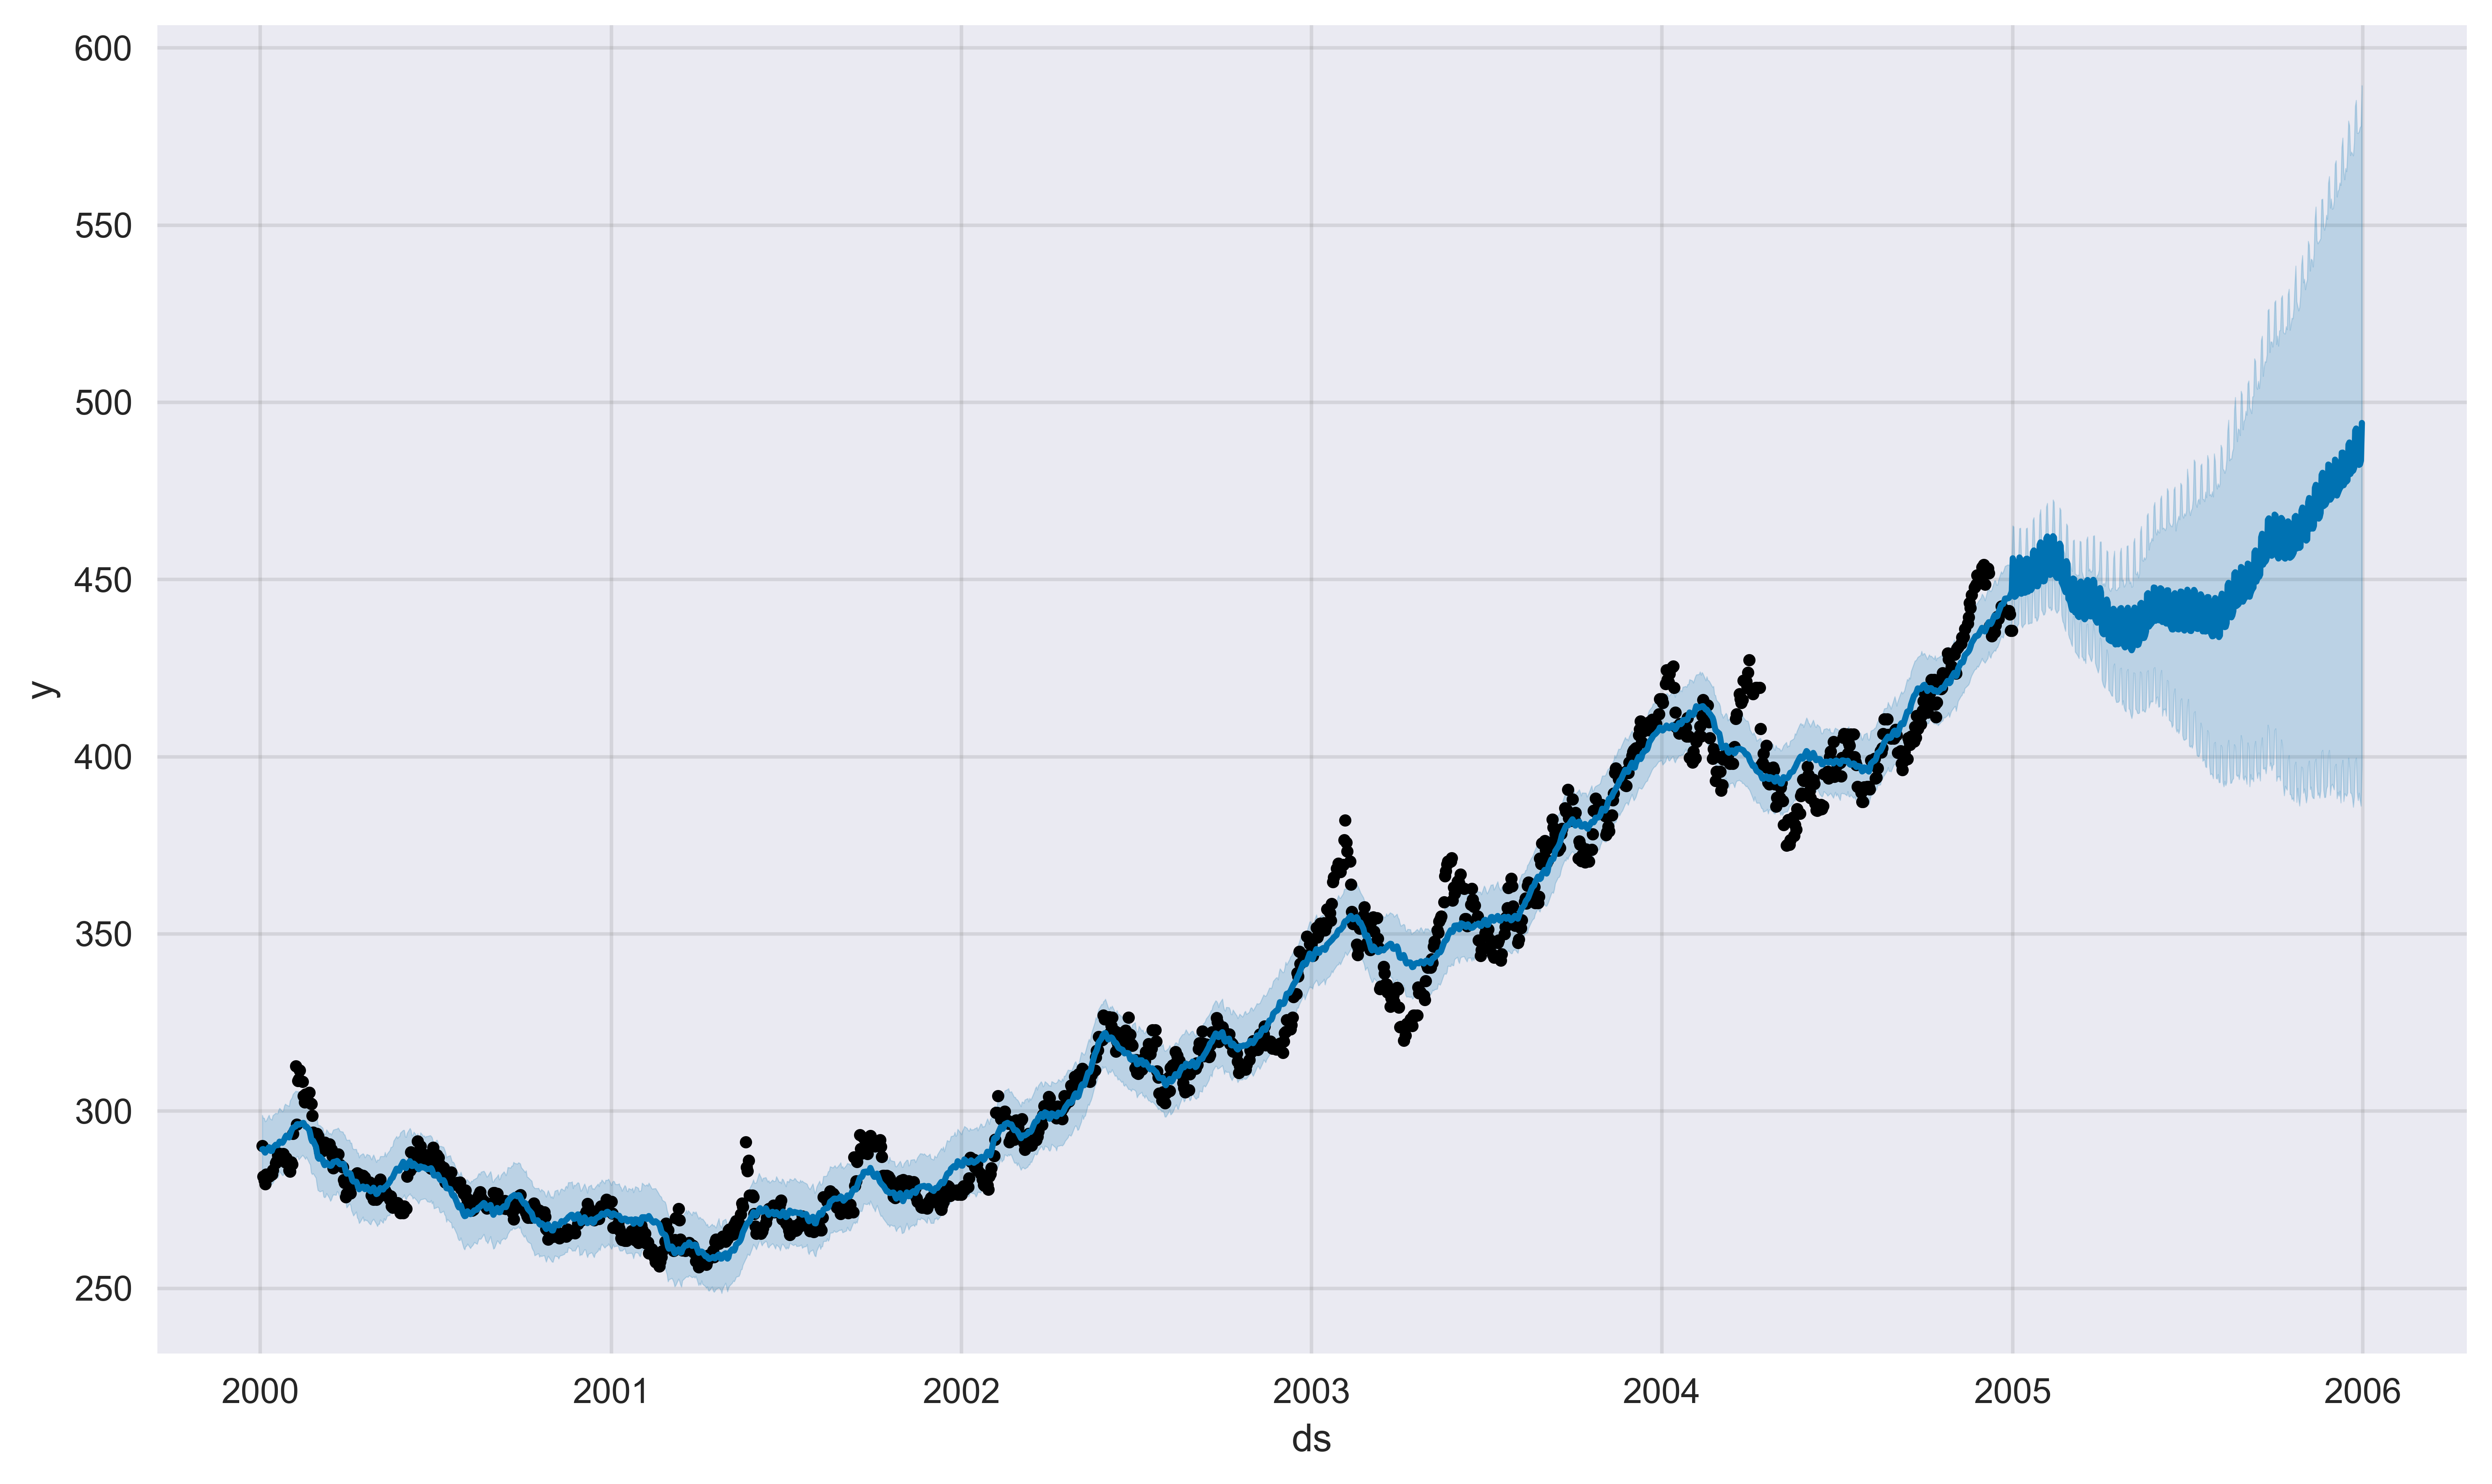

In [15]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im3.png')
plt.show()

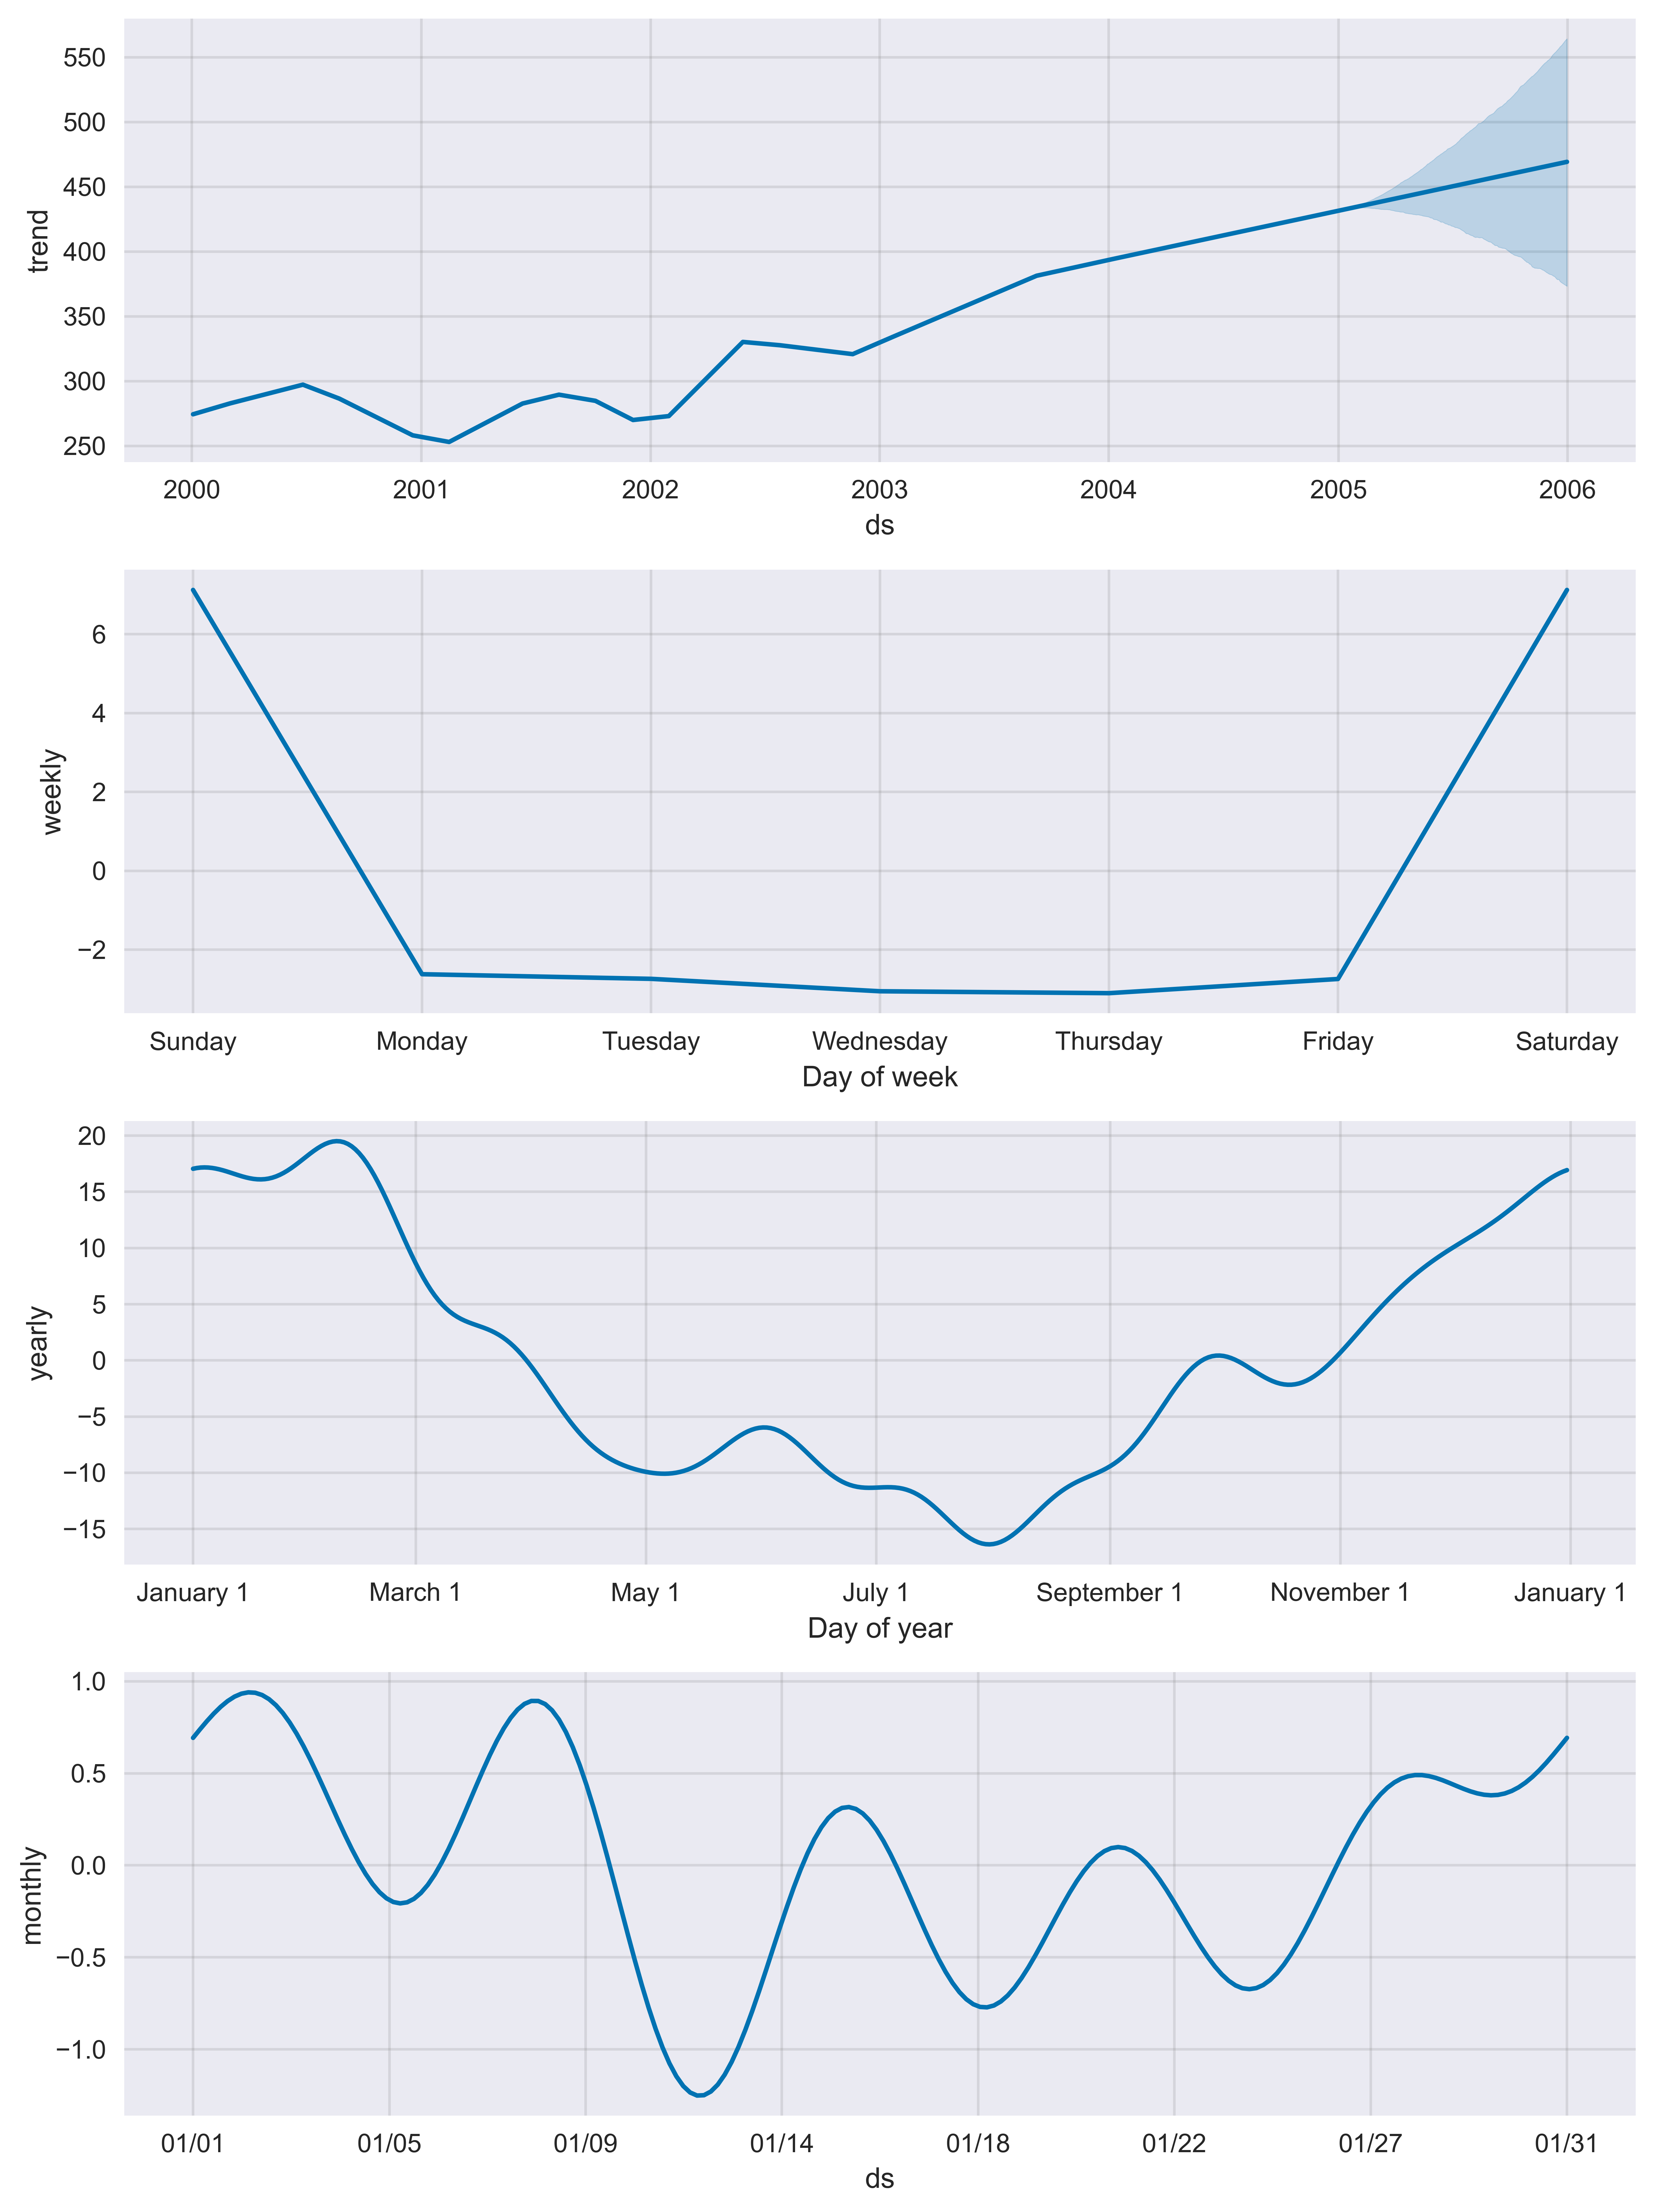

In [16]:
model_prophet.plot_components(df_pred)

plt.tight_layout()
#plt.savefig('images/ch3_im4.png')
plt.show()

In [17]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

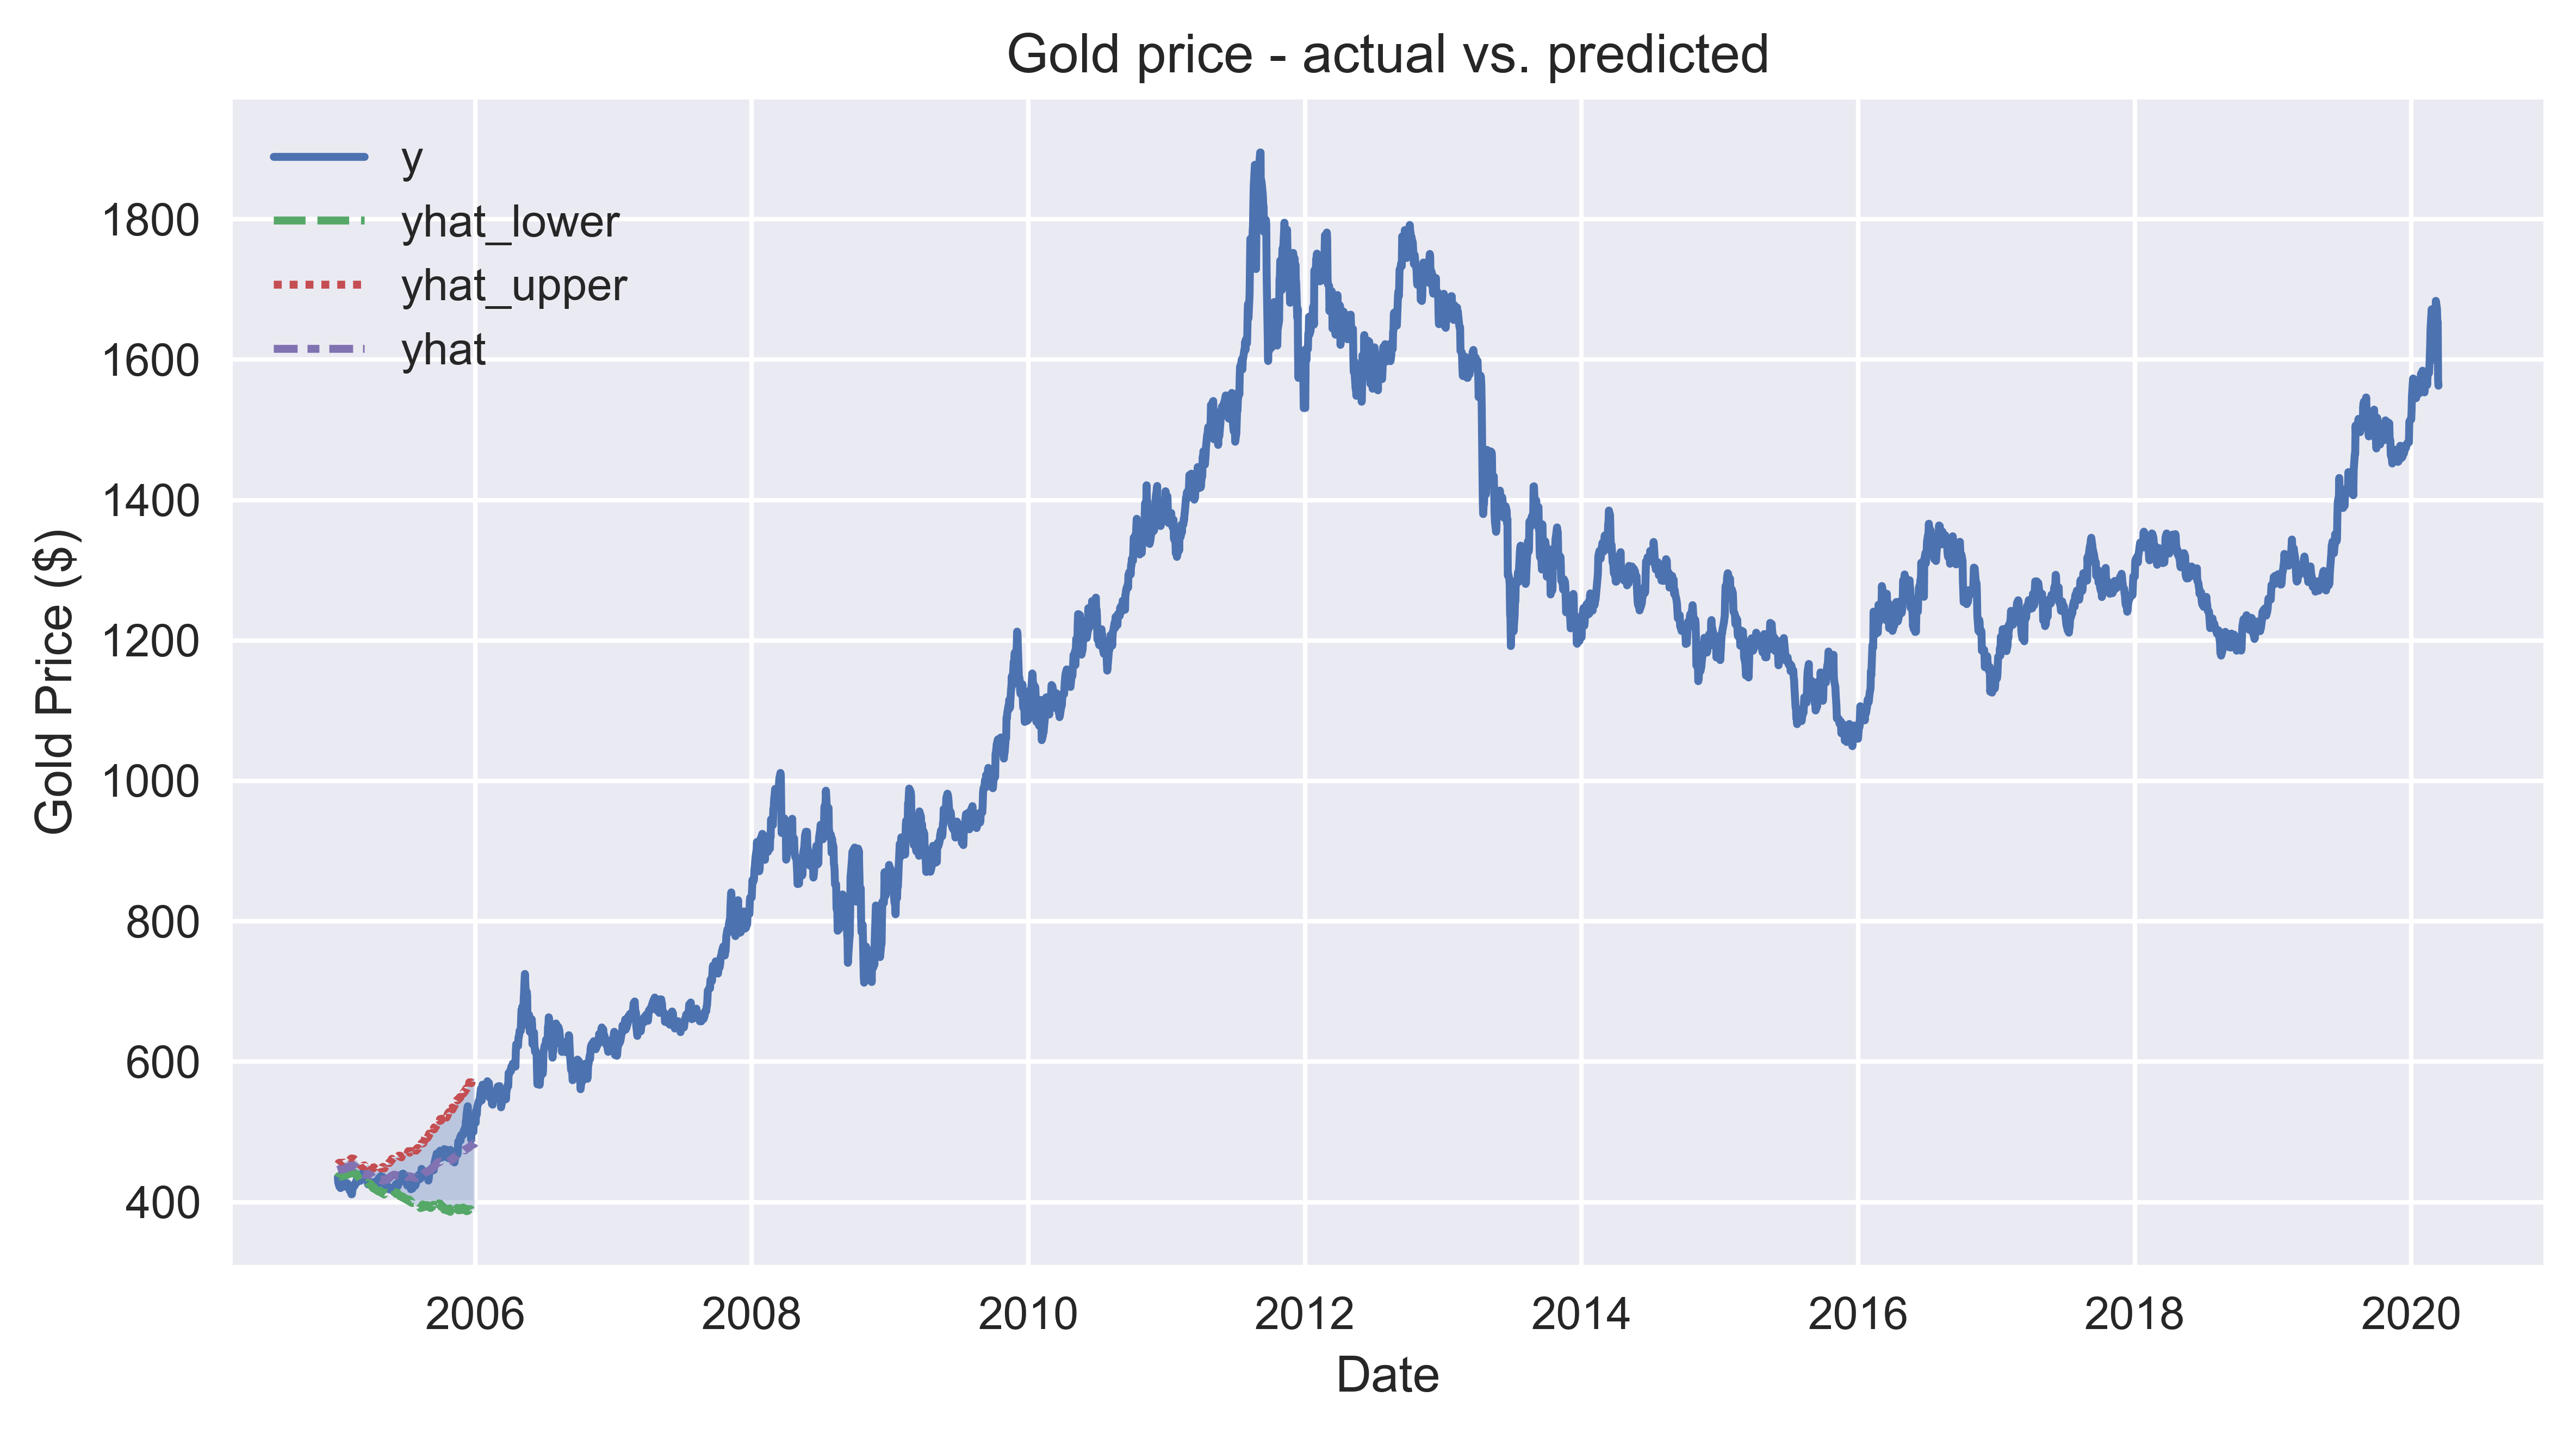

In [18]:
fig, ax = plt.subplots(1, 1)

ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(df_test.index,
               df_test.yhat_lower,
               df_test.yhat_upper,
               alpha=0.3)
ax.set(title='Gold price - actual vs. predicted',
      xlabel='Date',
      ylabel='Gold Price ($)')

plt.tight_layout()
plt.show()